## 1.Environment Setup & Imports

In [12]:
# === 1.3 Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

from surprise import SVDpp
from surprise import Dataset, Reader 
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

# Define path
data_path = '../datasets/student_grade.csv'

In [ ]:
df = pd.read_csv(data_path, low_memory=False)
df

## 2.Data Loading & Preprocessing

In [3]:
# === 2.1 Load Data ===
df = pd.read_csv(data_path, low_memory=False)

# === 2.2 Transform Data (Wide to Long) ===
id_vars = ['student_id']
df_long = pd.melt(df, id_vars=id_vars, var_name='course', value_name='grade')

# === 2.3 Clean Data ===
# Convert grade to numeric and remove invalid/empty grades
df_long['grade'] = pd.to_numeric(df_long['grade'], errors='coerce')
df_long_cleaned = df_long[(df_long['grade'] > 0.0) & (df_long['grade'].notna())].copy()

# === 2.4 Filter for 'INT' Courses Only ===
# This ensures the model only learns from INT courses
df_long_filtered = df_long_cleaned[df_long_cleaned['course'].astype(str).str.startswith('INT')].copy()

print(f"--- Data Preparation Complete ---")
print(f"Total records after cleaning: {len(df_long_cleaned)}")
print(f"Filtered to INT courses only: {len(df_long_filtered)}")
display(df_long_filtered)


--- Data Preparation Complete ---
Total records after cleaning: 43104
Filtered to INT courses only: 17468


,student_id,course,grade
25871,A246,INT102 WEB TECHNOLOGY,1.5
27143,A632,INT102 WEB TECHNOLOGY,3.0
27144,A086,INT102 WEB TECHNOLOGY,4.0
27145,A662,INT102 WEB TECHNOLOGY,4.0
27146,A066,INT102 WEB TECHNOLOGY,2.5
...,...,...,...
592988,A385,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,3.5
592990,A424,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5
593003,A111,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5
593005,A627,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5


## 3.Split Data to train and test set

In [4]:
# === 3.1 Load Data into Surprise Dataset ===
# Define rating scale (assuming grades are 1.0 to 4.0)
reader = Reader(rating_scale=(1, 4))
data = Dataset.load_from_df(df_long_filtered[['student_id', 'course', 'grade']], reader)


# === 3.2 Split Data ===
trainset, testset = train_test_split(data, test_size=0.30, random_state=42)

## 4.Model Training (SVD)

In [5]:
# === 3.3 Train the Model ===
print("--- Training SVD Model ---")
model = SVDpp(
    n_factors = 150,
    n_epochs  = 250,
    lr_all    = 0.01,
    reg_all   = 0.05,
    random_state = 42
)
model.fit(trainset)
print("Training complete.")



--- Training SVD Model ---
Training complete.


In [ ]:
model.predict('A458','INT540 SELECTED TOPIC IN INFORMATION TECHNOLOGY : BUSINESS FINANCE AND DATA ANALYTICS')

## 5.Test and evaluate model

In [6]:
# === 3.4 Evaluate Performance ===
print("\n--- Model Evaluation ---")
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)



--- Model Evaluation ---
RMSE: 0.5604
MAE:  0.4435


In [7]:
# === 4.1 Predict for Unknown Items ===
print("--- Generating Predictions for all missing pairs ---")
anti_testset = trainset.build_anti_testset()
all_predictions = model.test(anti_testset)

# === 4.2 Helper Function for Top-N ===
def get_top_n(predictions, n=5):
    """Return the top-N recommendation for each user from a set of predictions."""
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# === 4.3 Generate Top 5 Recommendations ===
top_n_recommendations = get_top_n(all_predictions, n=5)
print(f"Generated recommendations for {len(top_n_recommendations)} students.")

--- Generating Predictions for all missing pairs ---
Generated recommendations for 665 students.


In [ ]:
# === 5.1 Visualization Function ===
def visualize_topk_by_rank(top_n_recommendations, K=5, top_m=10):
    """
    Visualizes the frequency of recommended courses by rank.
    K: Number of recommendations per student.
    top_m: Number of top courses to show in the chart.
    """
    rows = []
    for student_id, recs in top_n_recommendations.items():
        for r, (course, score) in enumerate(recs[:K], start=1):
            rows.append({"rank": r, "course": course})

    if not rows:
        print("No recommendations to visualize.")
        return

    df_viz = pd.DataFrame(rows)
    rank_counters = {r: Counter(df_viz[df_viz["rank"] == r]["course"]) for r in range(1, K+1)}

    for r in range(1, K+1):
        counter = rank_counters[r]
        if not counter: continue

        most_common = counter.most_common(top_m)
        courses = [c for c, _ in most_common]
        counts  = [cnt for _, cnt in most_common]

        plt.figure(figsize=(10, 4))
        plt.bar(courses, counts, color='skyblue')
        plt.title(f"Top {top_m} Courses @ Rank {r}")
        plt.xlabel("Course")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# === 5.2 Run Visualization ===
print("--- Visualization of Recommendations ---")
visualize_topk_by_rank(top_n_recommendations, K=5, top_m=10)

# === 5.3 Create Final DataFrame ===
rows = []
for student_id, recs in top_n_recommendations.items():
    for rank, (course, predicted_grade) in enumerate(recs, start=1):
        # Note: Data was filtered for INT in step 2, so this check is just a safeguard
        if isinstance(course, str) and course.startswith("INT"):
            rows.append({
                "student_id": student_id,
                "rank": rank,
                "course": course,
                "predicted_grade": predicted_grade
            })

df_recommendations = pd.DataFrame(rows)

print("\n--- Final Recommendations Preview ---")
display(df_recommendations.head(15))

## 6.Confusion Matrix 8 grades

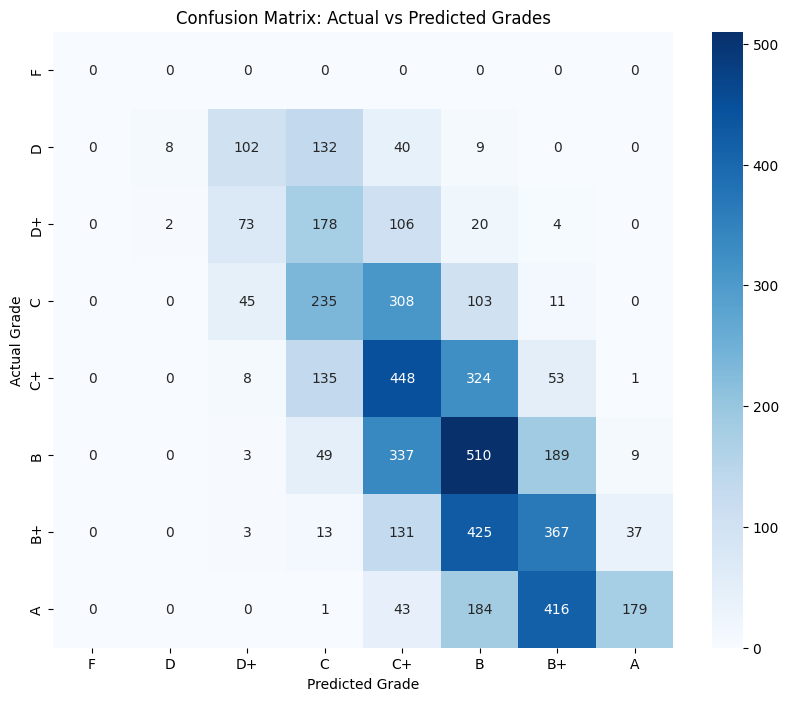


--- Detailed Classification Report ---
              precision    recall  f1-score   support

           F       0.00      0.00      0.00         0
           D       0.80      0.03      0.05       291
          D+       0.31      0.19      0.24       383
           C       0.32      0.33      0.33       702
          C+       0.32      0.46      0.38       969
           B       0.32      0.46      0.38      1097
          B+       0.35      0.38      0.36       976
           A       0.79      0.22      0.34       823

    accuracy                           0.35      5241
   macro avg       0.40      0.26      0.26      5241
weighted avg       0.43      0.35      0.33      5241



In [8]:
# 1. Define Mapping: Score -> Letter
# ต้องเรียงลำดับจากน้อยไปมาก เพื่อให้ Matrix สวยงาม
score_to_letter = {
    0.0: 'F', 1.0: 'D', 1.5: 'D+', 2.0: 'C', 2.5: 'C+',
    3.0: 'B', 3.5: 'B+', 4.0: 'A'
}

# สร้าง list ของเกรดที่เป็นไปได้ (เอาไว้ระบุ Labels)
# กรองเอาเฉพาะที่มีใน map (เผื่อกรณีข้อมูลไม่มี F)
valid_scores = sorted(score_to_letter.keys())
valid_labels = [score_to_letter[s] for s in valid_scores]

# 2. Helper function: หาเกรดที่ใกล้ที่สุด
def get_nearest_grade_key(pred_score):
    # หา key (คะแนน) ที่ใกล้ที่สุด
    return min(valid_scores, key=lambda x: abs(x - pred_score))

# 3. Prepare Data
y_true_letters = []
y_pred_letters = []

for pred in predictions:
    # 3.1 แปลง Actual Grade (r_ui) เป็น Letter
    # ใช้ get_nearest_grade_key เผื่อค่า r_ui มีทศนิยมเพี้ยนเล็กน้อย
    true_score_key = get_nearest_grade_key(pred.r_ui)
    y_true_letters.append(score_to_letter[true_score_key])

    # 3.2 แปลง Predicted Grade (est) เป็น Letter
    pred_score_key = get_nearest_grade_key(pred.est)
    y_pred_letters.append(score_to_letter[pred_score_key])

# 4. Generate Confusion Matrix
# สำคัญ: ต้องใส่ labels=valid_labels เพื่อบังคับลำดับ (D -> A)
cm = confusion_matrix(y_true_letters, y_pred_letters, labels=valid_labels)

# 5. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid_labels,
            yticklabels=valid_labels)

plt.title('Confusion Matrix: Actual vs Predicted Grades')
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')
plt.show()

# 6. Classification Report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_true_letters, y_pred_letters, target_names=valid_labels, zero_division=0,labels=valid_labels))

## 6.1 Confusion Matrix 5 grades


--- 5-Grade Classification Report ---
              precision    recall  f1-score   support

           F       0.00      0.00      0.00         0
           D       0.76      0.27      0.40       674
           C       0.52      0.67      0.59      1671
           B       0.57      0.72      0.64      2073
           A       0.79      0.22      0.34       823

    accuracy                           0.57      5241
   macro avg       0.53      0.38      0.39      5241
weighted avg       0.61      0.57      0.54      5241



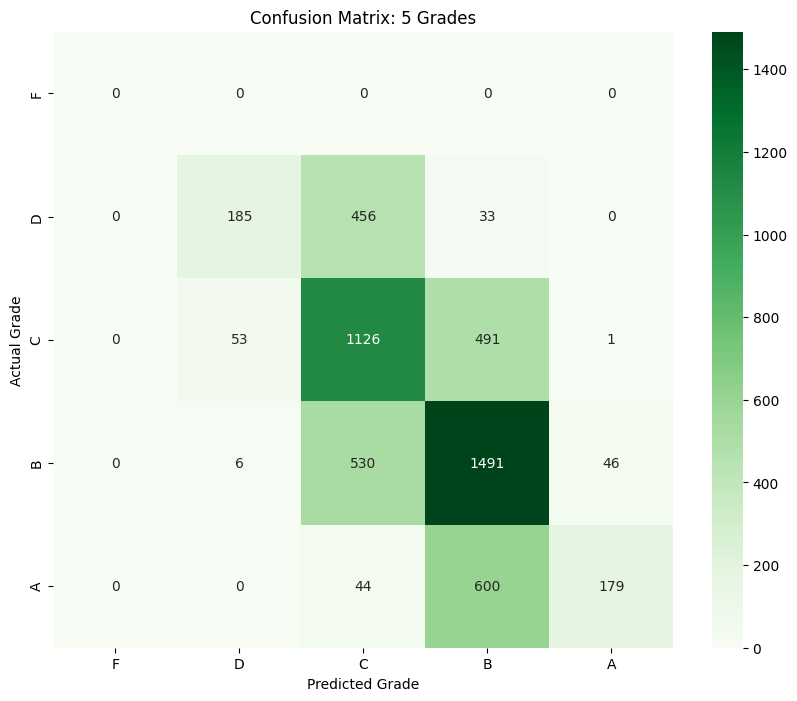

In [9]:
# Mapping: 5 Grades (Collapsing Plus grades)
score_to_letter_5 = {
    0.0: 'F', 
    1.0: 'D', 1.5: 'D', 
    2.0: 'C', 2.5: 'C',
    3.0: 'B', 3.5: 'B', 
    4.0: 'A'
}
valid_labels_5 = ['F', 'D', 'C', 'B', 'A']
# We still check against the full range of possible scores
valid_scores_all = [0.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

y_true_5 = [score_to_letter_5[get_nearest_grade_key(p.r_ui)] for p in predictions]
y_pred_5 = [score_to_letter_5[get_nearest_grade_key(p.est)] for p in predictions]

# Plot Heatmap 5 Grades
plt.figure(figsize=(10, 8))
cm_5 = confusion_matrix(y_true_5, y_pred_5, labels=valid_labels_5)
sns.heatmap(cm_5, annot=True, fmt='d', cmap='Greens', xticklabels=valid_labels_5, yticklabels=valid_labels_5)
plt.title('Confusion Matrix: 5 Grades')
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')

print("\n--- 5-Grade Classification Report ---")
print(classification_report(y_true_5, y_pred_5, target_names=valid_labels_5, labels=valid_labels_5, zero_division=0))

In [13]:
y_true_raw = [pred.r_ui for pred in predictions]
y_pred_raw = [pred.est for pred in predictions]

y_pred_rounded = [np.round(pred.est * 2) / 2 for pred in predictions]

# 2. คำนวณ R2 Score
r2 = r2_score(y_true_raw, y_pred_raw)
r2Rounded = r2_score(y_true_raw, y_pred_rounded)


print(f"R2 Score: {r2:.4f}")
print(f"R2 Score Rounded: {r2Rounded:.4f}")

R2 Score: 0.5707
R2 Score Rounded: 0.5403


In [14]:
for epoch in range(5):
    nmf = SVD(n_factors=3, n_epochs=epoch+1, random_state=42)
    nmf.fit(trainset)

    print(f"\nEpoch {epoch+1}")
    print(nmf.pu[:3])   # user 3 คนแรก

NameError: name 'SVD' is not defined